# Runs finite state space continuous time Markov chain with N listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import csv
import time
import itertools
from numpy import random
from operator import itemgetter
import importlib
import multiprocessing as mp
import json
import math

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import experiment_helper
import exp_wrapper 

import finite_sim as sim
import finite_sim_wrapper as sim_wrapper

In [3]:
importlib.reload(exp_wrapper)
importlib.reload(experiment_helper)
importlib.reload(sim)
importlib.reload(sim_wrapper)

<module 'finite_sim_wrapper' from '/home/ralur/herding-bias/finite_sim_wrapper.py'>

# Setting parameters model parameters

In [4]:
alpha = 1
epsilon = 1
tau = 1
lams = [ .1, 1, 10, 100, 1000]


tsr_ac_al_values = [.5]
cr_a_C = 0.5
lr_a_L = 0.5

tsr_est_types = ['tsr_est_naive', 'tsri_1.0','tsri_2.0']+['mrd_avg']


In [5]:
customer_types = ['c1']
listing_types = ['l']
exp_conditions = ['control', 'treat']
rhos_pre_treat = {'l':1} #adds up to 1
customer_proportions = {'c1':1} #adds up to 1

# used for multiplicative utilities
customer_type_base = {'c1':.315 }
listing_type_base = {'l':1}
exp_condition_base = {'control':1, 'treat':1.25}

vs = {}
#multiplicative -- default
for c in customer_types:
    vs[c] = {}
    vs[c]['treat'] = {}   
    vs[c]['control'] = {}
    for l in listing_types:
        for e in exp_conditions:
            vs[c][e][l] = round(customer_type_base[c]
                                *exp_condition_base[e]
                                *listing_type_base[l],4)

for c in customer_types:
    print("customer", c)
    print("control", vs[c]['control'])
    print("treatment", vs[c]['treat'], "\n")
print('Rhos:', rhos_pre_treat)
print("Customer Proportions:", customer_proportions)

customer c1
control {'l': 0.315}
treatment {'l': 0.3937} 

Rhos: {'l': 1}
Customer Proportions: {'c1': 1}


In [6]:
params = sim_wrapper.calc_all_params(listing_types, rhos_pre_treat, 
                                     customer_types, customer_proportions, vs, 
                                    alpha, epsilon, tau, lams,
                                    tsr_ac_al_values, cr_a_C, lr_a_L)

In [7]:
T_0 = 5
T_1 = 40

# normalizes time horizon by min(lam, tau)
T_start = {lam: T_0/lam for lam in lams}
T_end = {lam: T_1/lam for lam in lams}

varying_time_horizons = True

n_runs = 10
n_listings = 100

choice_set_type = 'alpha' #customers sample items into consideration set with prob alpha
k = None

# Naive designs and estimators over time

In [8]:
def get_events(herding, recency, exp_type='cr_params'):

    s_full = {l: int(n_listings*rhos_pre_treat[l]) for l in rhos_pre_treat}
    lam = lams[1]

    # normalizes time horizon by min(lam, tau)
    T_start = T_0/min(lam,tau)
    T_end = T_1/min(lam,tau)

    lam_gammas = {c: lam for c in customer_proportions}
    vs = {}
    #multiplicative -- default
    for e in exp_conditions:
        vs[e] = {}
        for c in customer_types:
            vs[e][c] = {}
            for l in listing_types:
                vs[e][c][l] = round(customer_type_base[c]
                                    *exp_condition_base[e]
                                    *listing_type_base[l],4)
                
    def run_sim_same_params(herding, recency, vs):
        return sim.run_mc_listing_ids(choice_set_type="alpha", 
                   n=n_listings, 
                   k=None, 
                   s_0=copy.copy(s_full), 
                   s_full=s_full, 
                   T=T_end, 
                   thetas=rhos_pre_treat, 
                   gammas=customer_proportions, 
                   vs=vs, 
                   tau=tau, 
                   lam_gammas=lam_gammas, 
                   alpha=alpha, 
                   epsilon=epsilon, 
                   run_number=1, 
                   herding=herding, 
                   recency=recency)["events"]

    mc_treat = run_sim_same_params(herding, recency, vs['treat'])

    mc_control = run_sim_same_params(herding, recency, vs['control'])
    
    exp_params = params[exp_type][lam]
    s_full_exp = {l: int(n_listings*exp_params['rhos_exp'][l]) for l in exp_params['rhos_exp']}

    mc_exp = sim.run_mc_listing_ids(choice_set_type="alpha", 
               n=n_listings, 
               k=None, 
               s_0=copy.copy(s_full_exp), 
               s_full=s_full_exp, 
               T=T_end, 
               thetas=exp_params["rhos_exp"], 
               gammas=exp_params["gammas_exp"], 
               vs=exp_params['v_gammas_exp'], 
               tau=tau, 
               lam_gammas=exp_params['lam_gammas_exp'], 
               alpha=alpha, 
               epsilon=epsilon, 
               run_number=1, 
               herding=herding, 
               recency=recency)["events"]
    
    def get_customer_choice_events(df, exp=None):
        if exp == "c1_control" or exp == "c1_treat":
            new_df = df.loc[pd.notnull(df['choice_type']) & (df['customer_type'] == exp)]
        else:
            new_df = df.loc[pd.notnull(df['choice_type'])]
        return new_df[["choice_type", "time"]].set_index(["time"])

    customer_events_t = get_customer_choice_events(mc_treat)
    customer_events_c = get_customer_choice_events(mc_control) 
    if exp_type == "cr_params":
        customer_events_exp_control = get_customer_choice_events(mc_exp, exp="c1_control") 
        customer_events_exp_treat = get_customer_choice_events(mc_exp, exp="c1_treat")
    if exp_type == "lr_params":
        customer_events_exp_control = get_customer_choice_events(mc_exp, exp="l_control") 
        customer_events_exp_treat = get_customer_choice_events(mc_exp, exp="l_treat")
    return (customer_events_t, customer_events_c, customer_events_exp_treat, customer_events_exp_control)


In [ ]:
herding = True
recency = False
exp_type = "lr_params"
N = 5000

T_0 = 5
T_1 = 60

lr_a_L = 0.5



def get_concat(events):
    concat_df = pd.concat(events).sort_index()
    concat_df["not_outside"] = concat_df["choice_type"] != "outside_option"
    return concat_df

def get_mean_t(df, t_0, t_1, l_type):
    if l_type == "l_treat" or l_type == "l_control":
        return (df[(df.index >= t_0) & (df.index <= t_1)]["choice_type"] == l_type).mean()
    else:
        return df[(df.index >= t_0) & (df.index <= t_1)].mean()["not_outside"]

def get_mean(df, l_type = None):
    return np.array([get_mean_t(df, t_0, t_0+1, l_type) for t_0 in range(T_1)])


events = [get_events(herding, recency, exp_type) for _ in range(N)]
customer_events_t, customer_events_c, customer_events_exp_treat, customer_events_exp_control = zip(*events)

avgs_t = get_mean(get_concat(customer_events_t))
avgs_c = get_mean(get_concat(customer_events_c))
if exp_type == "lr_params":
    avgs_exp_treat = get_mean(get_concat(customer_events_exp_treat), l_type = 'l_treat')
    avgs_exp_control = get_mean(get_concat(customer_events_exp_control), l_type = 'l_control')
else:
    avgs_exp_treat = get_mean(get_concat(customer_events_exp_treat))
    avgs_exp_control = get_mean(get_concat(customer_events_exp_control))

In [ ]:
def get_sds(dfs_t, dfs_c):
    for dfs in [dfs_t, dfs_c]:
        for df in dfs:
            df["not_outside"] = df["choice_type"] != "outside_option" 
    if exp_type == "lr_params":
        means = [np.array(get_mean(df_t, l_type="l_treat"))-np.array(get_mean(df_c, l_type="l_control")) for df_t,df_c  in zip(dfs_t, dfs_c)]
    else:
        means = [np.array(get_mean(df_t))-np.array(get_mean(df_c)) for df_t,df_c  in zip(dfs_t, dfs_c)]
    return np.std(np.vstack(means), axis=0)/math.sqrt(len(dfs_t))

sds_gte = get_sds(customer_events_t, customer_events_c)
sds_cr = get_sds(customer_events_exp_treat, customer_events_exp_control)

In [ ]:
def get_sds_bias(dfs_t, dfs_c, dfs_exp_t, dfs_exp_c):
    for dfs in [dfs_t, dfs_c, dfs_exp_t, dfs_exp_c]:
        for df in dfs:
            df["not_outside"] = df["choice_type"] != "outside_option" 
    if exp_type == "lr_params":
        means = [(np.array(get_mean(df_exp_t, l_type="l_treat")) - np.array(get_mean(df_exp_c, l_type="l_control"))) - (np.array(get_mean(df_t))-np.array(get_mean(df_c))) for df_t,df_c,df_exp_t,df_exp_c  in zip(dfs_t, dfs_c, dfs_exp_t, dfs_exp_c)]
    else:
        means = [(np.array(get_mean(df_exp_t))-np.array(get_mean(df_exp_c))) - (np.array(get_mean(df_t))-np.array(get_mean(df_c))) for df_t,df_c,df_exp_t,df_exp_c  in zip(dfs_t, dfs_c, dfs_exp_t, dfs_exp_c)]
    return np.std(np.vstack(means), axis=0)/math.sqrt(len(dfs_t))

sds_bias = get_sds_bias(customer_events_t, customer_events_c, customer_events_exp_treat, customer_events_exp_control)

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(18,4))

def purchase_rate_plot(ax, avgs_t, avgs_c, avgs_exp_treat, avgs_exp_control, prefix = "CR"):
    ax.plot(avgs_t, label="Global treatment")
    ax.plot(avgs_c, label="Global control")
    ax.plot(avgs_exp_treat, label=prefix + " treatment")
    ax.plot(avgs_exp_control, label=prefix + " control")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Purchase rate")
    
def effect_size_plot(ax, avgs_t, avgs_c, avgs_exp_treat, avgs_exp_control, sds_gte, sds_cr):
    effects = avgs_t - avgs_c
    ax.plot(effects, label="Global average treatment effect")
    ax.fill_between(range(T_1), effects + sds_gte[0], effects - sds_gte[1], alpha=0.2, label="S.E. of GATE")
    effects = avgs_exp_treat - avgs_exp_control
    ax.plot(effects, label="Estimate using difference-in-means")
    ax.fill_between(range(T_1), effects + sds_cr[0], effects - sds_cr[1], alpha=0.2, label="S.E. of estimator")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Effect size")
    
def bias_plot(ax, avgs_t, avgs_c, avgs_exp_treat, avgs_exp_control, sds_bias):
    biases = (avgs_exp_treat - avgs_exp_control) - (avgs_t - avgs_c)
    ax.plot(biases, label="Bias of difference-in-means estimator")
    ax.fill_between(range(T_1), biases + sds_bias[0], biases - sds_bias[1], alpha=0.2, label="S.E. of estimator")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Bias")

purchase_rate_plot(axes[0], avgs_t, avgs_c, avgs_exp_treat, avgs_exp_control, prefix="LR")
effect_size_plot(axes[1], avgs_t, avgs_c, avgs_exp_treat, avgs_exp_control, sds_gte, sds_cr)
bias_plot(axes[2], avgs_t, avgs_c, avgs_exp_treat, avgs_exp_control, sds_bias)
plt.savefig("lr_herdingovertime.png", dpi=1000)

# Simulations

Setting simulation parameters. Remaining model parameters as defined in mean field parameters.

Define choice set type. If 'alpha', customers sample items into consideration set with prob alpha. If 'finite_k', each customer draws a fixed $k$ number of items into their consideration set.

## Herding

In [ ]:
events_herding = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True)
est_stats_herding = sim_wrapper.calc_all_ests_stats("sample_", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params, fname_suffix="_herding.csv"
                                           )
est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

## Competition

In [ ]:
events_competition = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=False)
est_stats_competition = sim_wrapper.calc_all_ests_stats("sample_", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_competition, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params, fname_suffix="_competition.csv"
                                           )
est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

## Herding, no recency bias

In [ ]:
events_herding_no_recency = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True, recency=False)
est_stats_herding_no_recency = sim_wrapper.calc_all_ests_stats("sample_", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding_no_recency, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params, fname_suffix="_herding_no_recency.csv"
                                           )
est_stats_herding_no_recency = est_stats_herding_no_recency.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

# Simulations, varying relative user arrival time

In [ ]:
events_herding = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True)
est_stats_herding = sim_wrapper.calc_all_ests_stats("sample_", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params, fname_suffix="_herding.csv"
                                           )
est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })



# Visualizations

## Visualizations: Herding

In [305]:
est_stats_herding = pd.read_csv("sample_total_stats_herding1000.csv", index_col=["estimator_type", "lambda"])

est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })
#est_stats_herding = est_stats_herding.loc[["Customer-Side", "Product-Side", "TSR-Naive", "TSRI-1", "TSRI-2"]]
est_stats_herding = est_stats_herding.loc[["Customer-Side", "Product-Side"]]

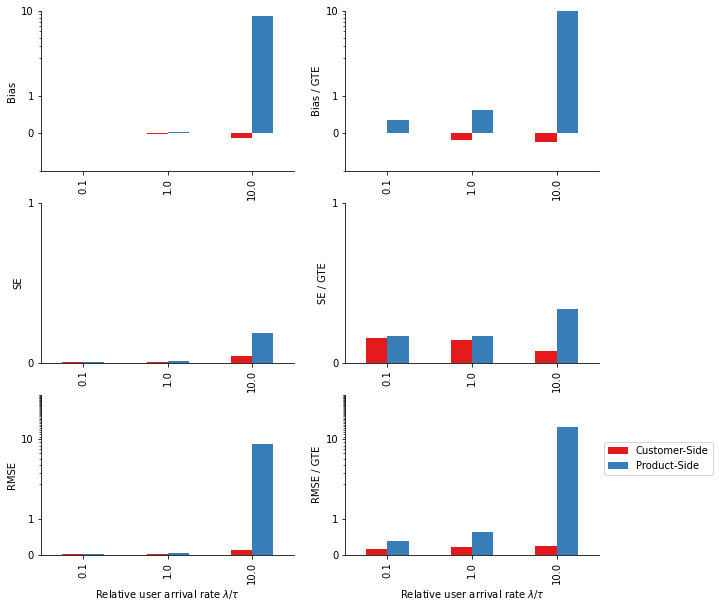

In [311]:
sim_wrapper.plot_all_stats(est_stats_herding, "", yscale="symlog")
plt.savefig("herding.svg")

## Visualizations: competition

In [312]:
est_stats_competition = pd.read_csv("sample_total_stats_competition.csv", index_col=["estimator_type", "lambda"])

est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })
#est_stats_competition = est_stats_competition.loc[["Customer-Side", "Product-Side", "TSR-Naive", "TSRI-1", "TSRI-2"]]
est_stats_competition = est_stats_competition.loc[["Customer-Side", "Product-Side"]]

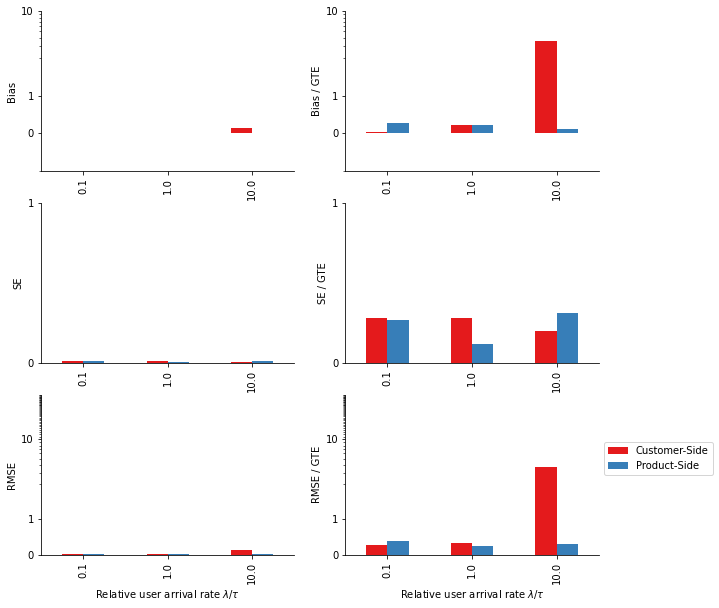

In [313]:
sim_wrapper.plot_all_stats(est_stats_competition, "", yscale="symlog")
plt.savefig("competition.svg")

## Visualizations: Herding, no recency

In [387]:
est_stats_herding_no_recency = pd.read_csv("sample_total_stats_herding_no_recency100.csv", index_col=["estimator_type", "lambda"])

est_stats_herding_no_recency = est_stats_herding_no_recency.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })
est_stats_herding_no_recency = est_stats_herding_no_recency.loc[["Customer-Side", "Product-Side", "TSR-Naive", "TSRI-1", "TSRI-2"]]

(<Figure size 720x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

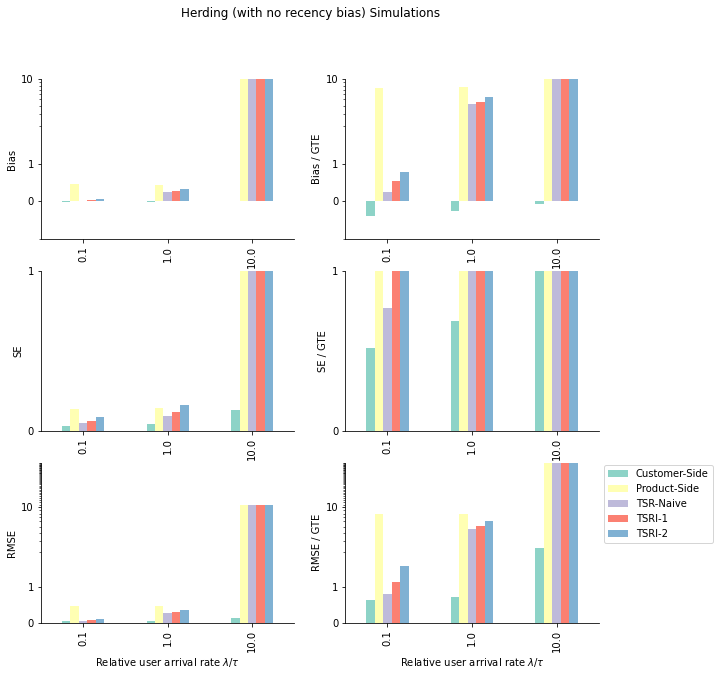

In [388]:
sim_wrapper.plot_all_stats(est_stats_herding_no_recency, "Herding (with no recency bias) Simulations", yscale="symlog")